# Goodreads Book Ratings Predictions

### Content
1. Exploring Data.
2. Analyze Data through visualizations.
3. Data Preparation e.g.: [Ordinal Encoding, Handling Missing Values].
4. Feature Engineering.
5. Building Multiple Machine Learning Models.
6. Compare models accuracy on training data.
7. Make predictions using each model.
8. Compare models accuracy on test data.
9. Compare training VS test score for each model
10. Extract best model for use in the bookstore to drive decisions.

In [2]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=69c385be0c86d46c9630ec8d7c85933ba25b550d1d375ad04b49a4af6473d917
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
from google.colab import drive
from eli5.sklearn import PermutationImportance
import eli5

# 1. Importing and Exploring Dataset

In [5]:
drive.mount('/content/drive')
df = pd.read_csv('books.csv', on_bad_lines='skip')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [3]:
df.describe() # Generate the summary table of the data

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [15]:
df.dtypes # Check the data types of all columns

bookID                         int64
title                         object
authors                       object
average_rating               float64
isbn                          object
isbn13                         int64
language_code                float64
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
year                           int64
num_occ                        int64
dtype: object

In [5]:
df.isnull().sum() # Check if there's any missing value

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

# 2. Data Cleaning & Feature Engineering

In [6]:
from sklearn.preprocessing import OrdinalEncoder

encoding = {'language_code':{'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng'}} # Unify the langauge codes
df.replace(encoding, inplace=True)

enc = OrdinalEncoder()
enc.fit(df[['language_code']])
df[['language_code']] = enc.fit_transform(df[['language_code']]) # Apply ordinal encoding on language_code to convert it into numerical column

In [7]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce') # Convert data type of publication_date from object into date type
df[df['publication_date'].isnull()]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
8177,31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,0553575104,9780553575101,2.0,718,10608,295,NaT,Bantam Books
11094,45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9782070323289,4.0,640,15,2,NaT,Folio histoire


### Since there are only 2 books with courrpted dates, we googled these 2 books to get the publication dates and put them manually

In [8]:
df.loc[df.bookID == 31373, 'publication_date'] = '1999-10-01 00:00:00'
df.loc[df.bookID == 45531, 'publication_date'] = '1975-10-01 00:00:00'

In [9]:
df['year'] = pd.DatetimeIndex(df['publication_date']).year # Extract year of publication in a separate column

df.rename(columns = {'  num_pages': 'num_pages'}, inplace=True) # Rename the column to remove leading whitespaces

In [21]:
df['num_occ'] = df.groupby('title')['title'].transform('count') # Add a new feature which has the number of occurences of each book

### Calculating New Features

In [23]:
df['rate_occ'] = df['average_rating'] * df['num_occ']
df['rate_weight'] = df['average_rating'] * df['text_reviews_count']
df['rate_weight_2'] = df['average_rating'] * df['ratings_count']
df['rate_per_pages'] = df['average_rating'] * df['num_pages']

In [24]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'year', 'num_occ', 'rate_occ',
       'rate_weight', 'rate_weight_2', 'rate_per_pages'],
      dtype='object')

# 3. Data Analysis & Visualizations

<ipython-input-25-424e18fb6db5>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
<ipython-input-25-424e18fb6db5>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<Axes: >

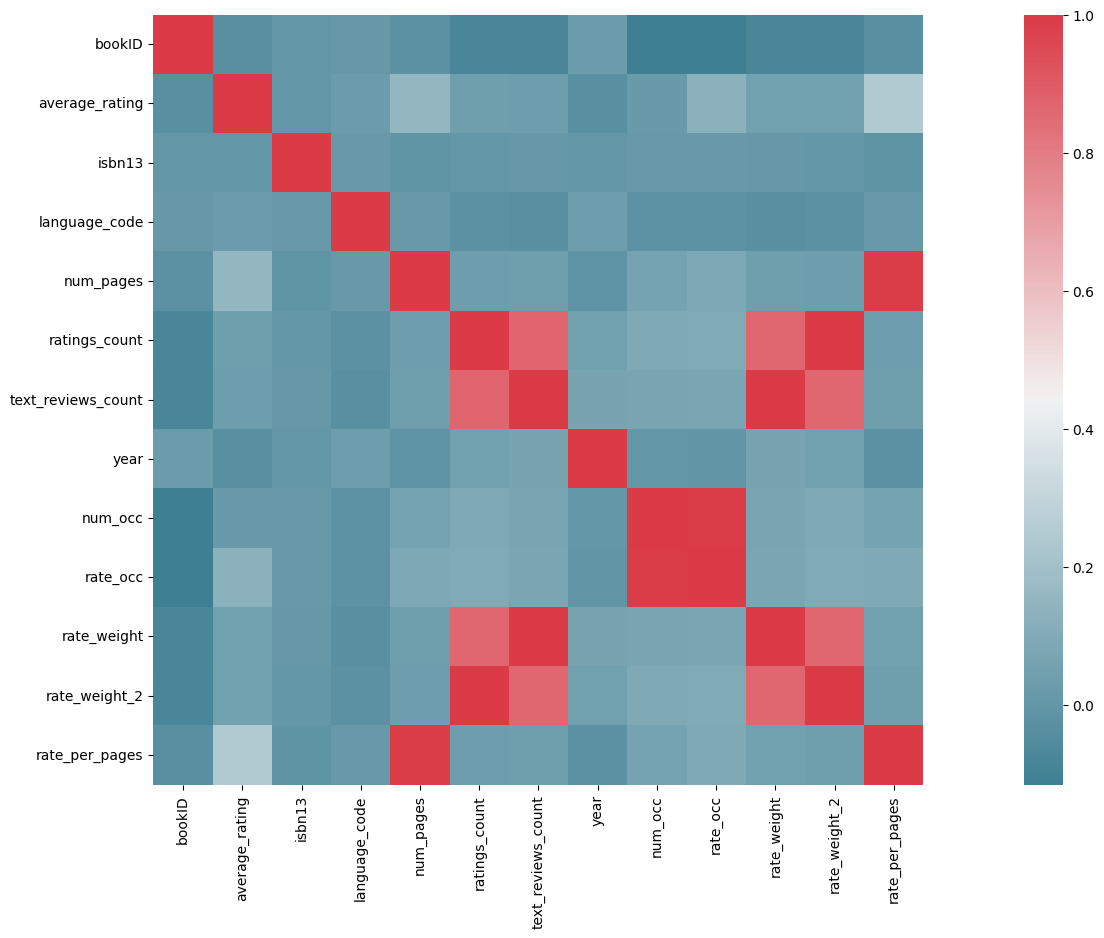

In [25]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

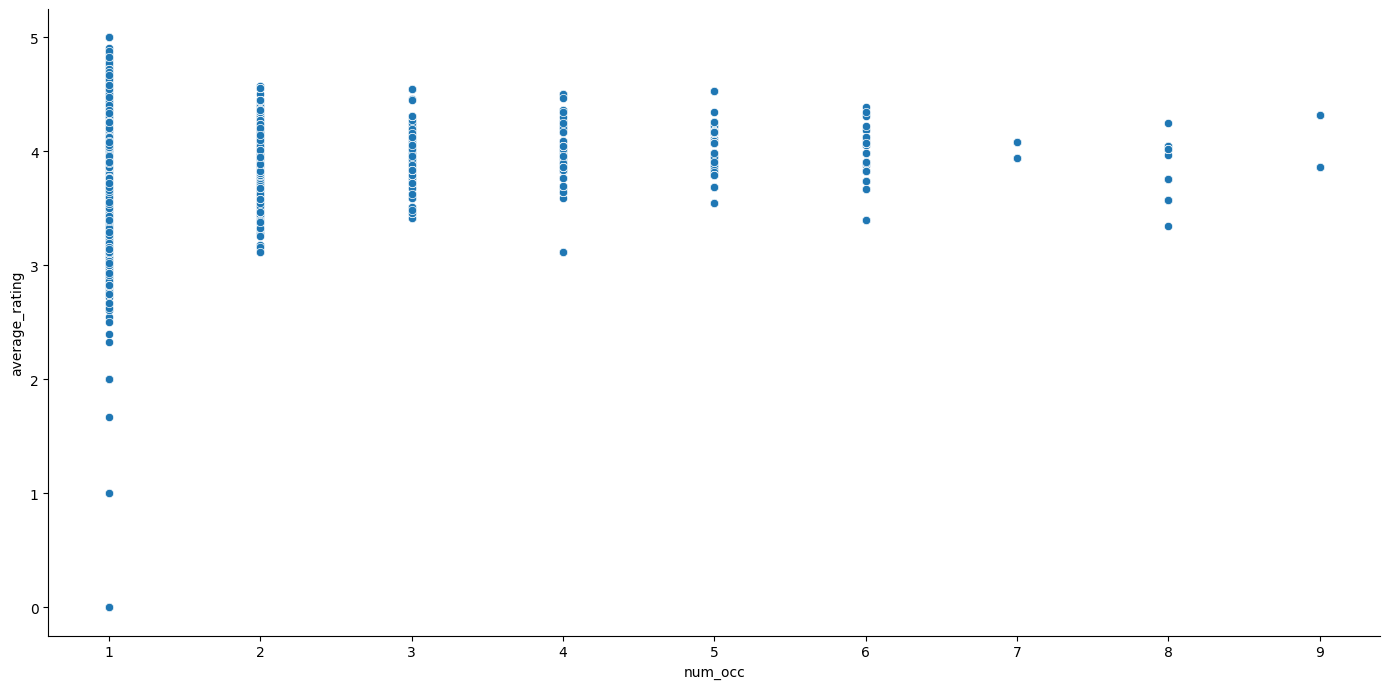

In [26]:
sns.relplot(x="num_occ", y="average_rating", data=df, height=7, aspect = 2)

### The upper visual says that any book appeared more than once has a good/high rating

<Axes: xlabel='year', ylabel='average_rating'>

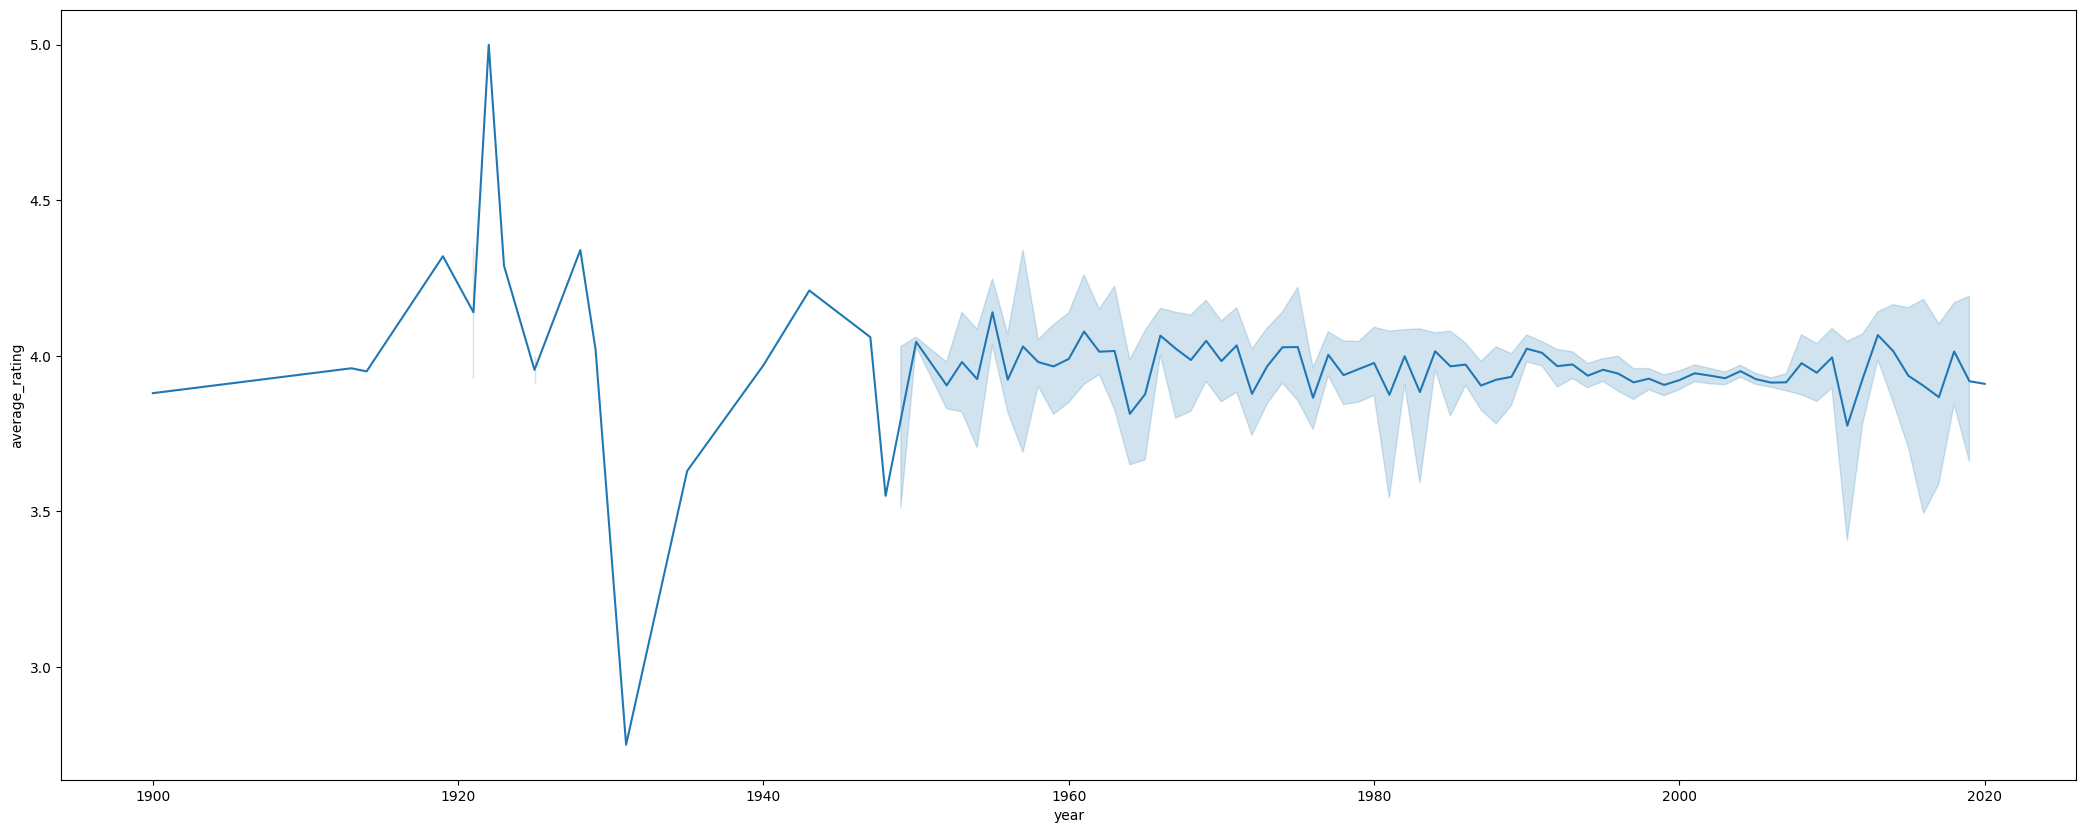

In [27]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
sns.lineplot(x="year", y="average_rating", data=df)

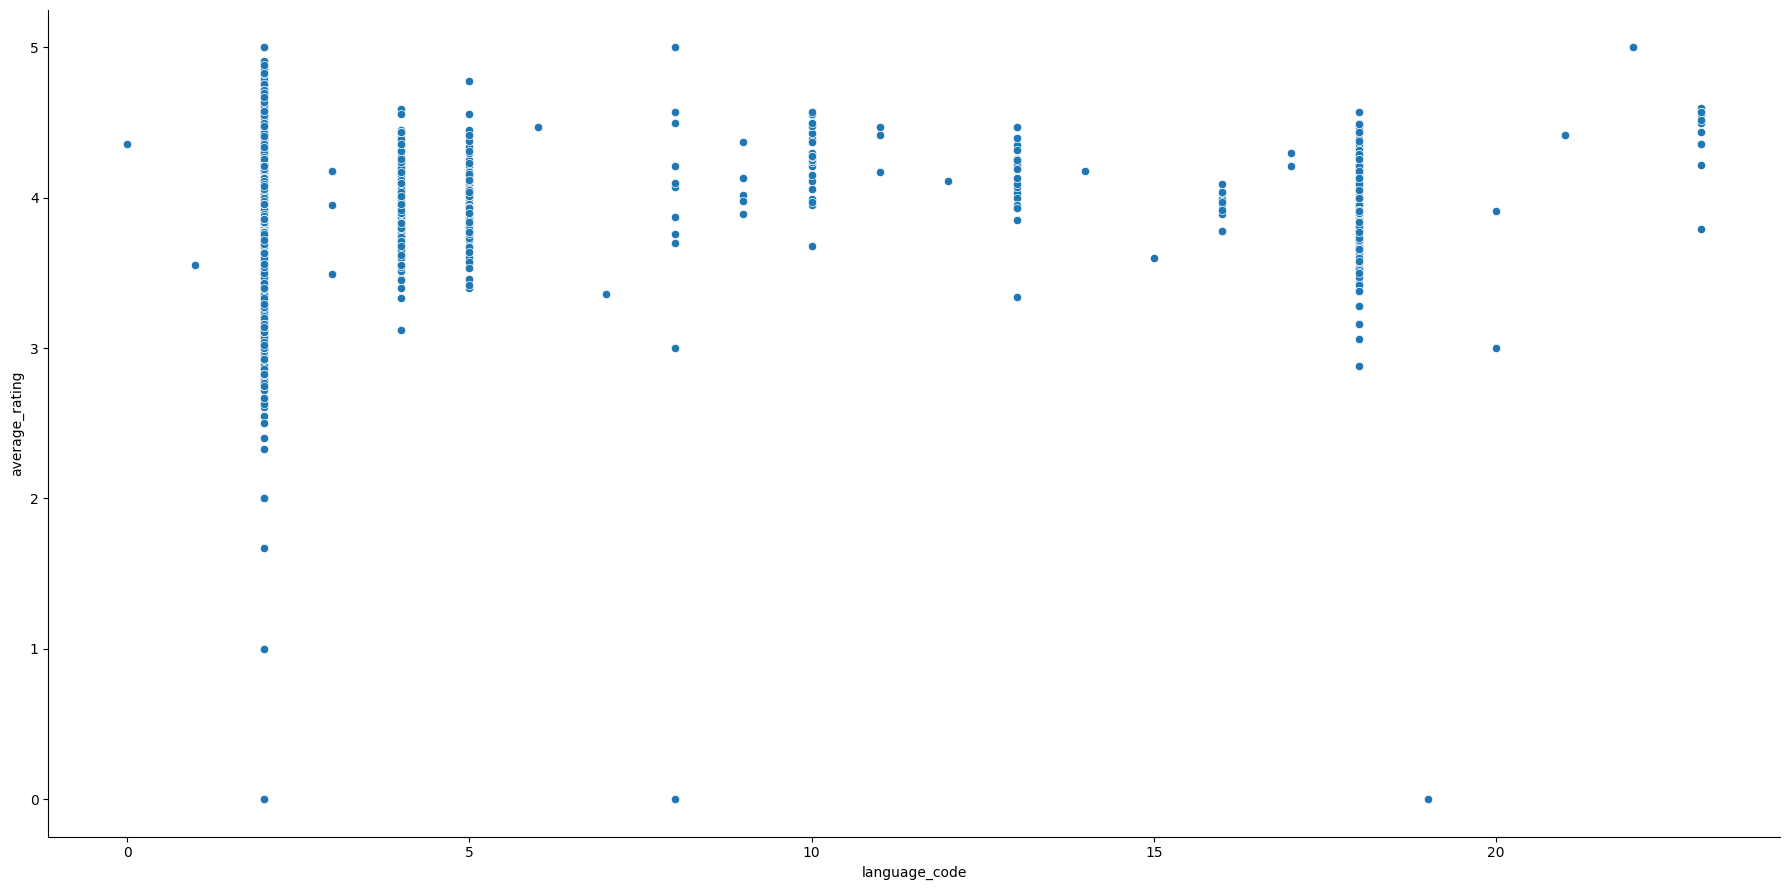

In [28]:
sns.relplot(x="language_code", y="average_rating", data=df, height=9, aspect = 2)

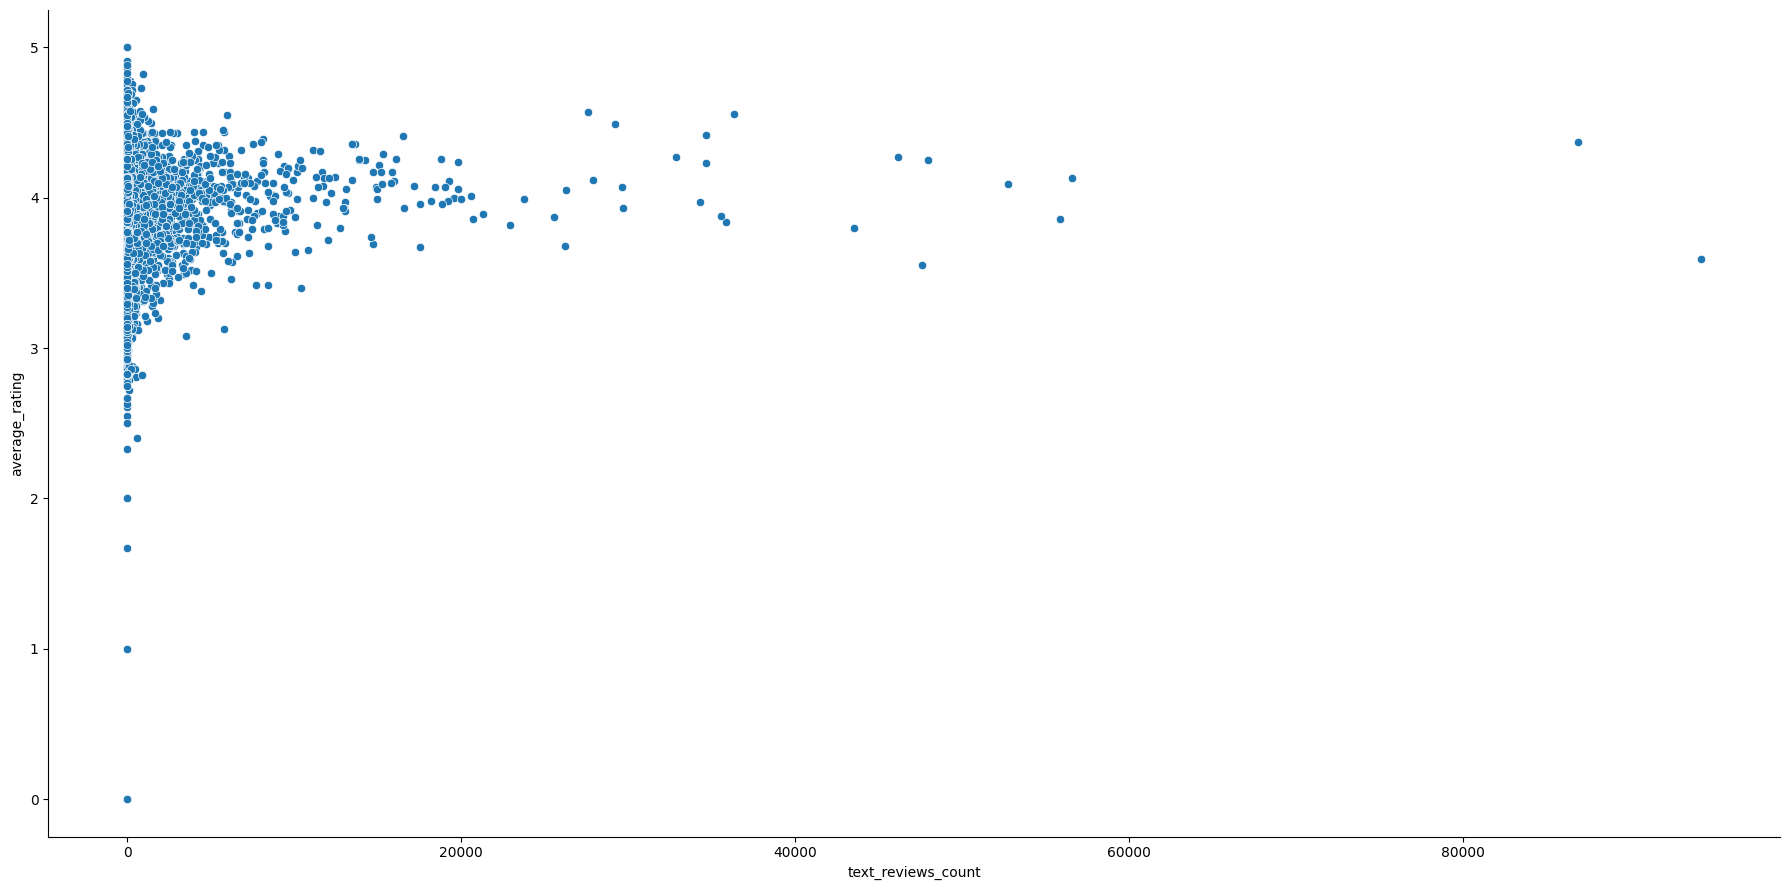

In [29]:
sns.relplot(x="text_reviews_count", y="average_rating", data=df, height=9, aspect = 2)

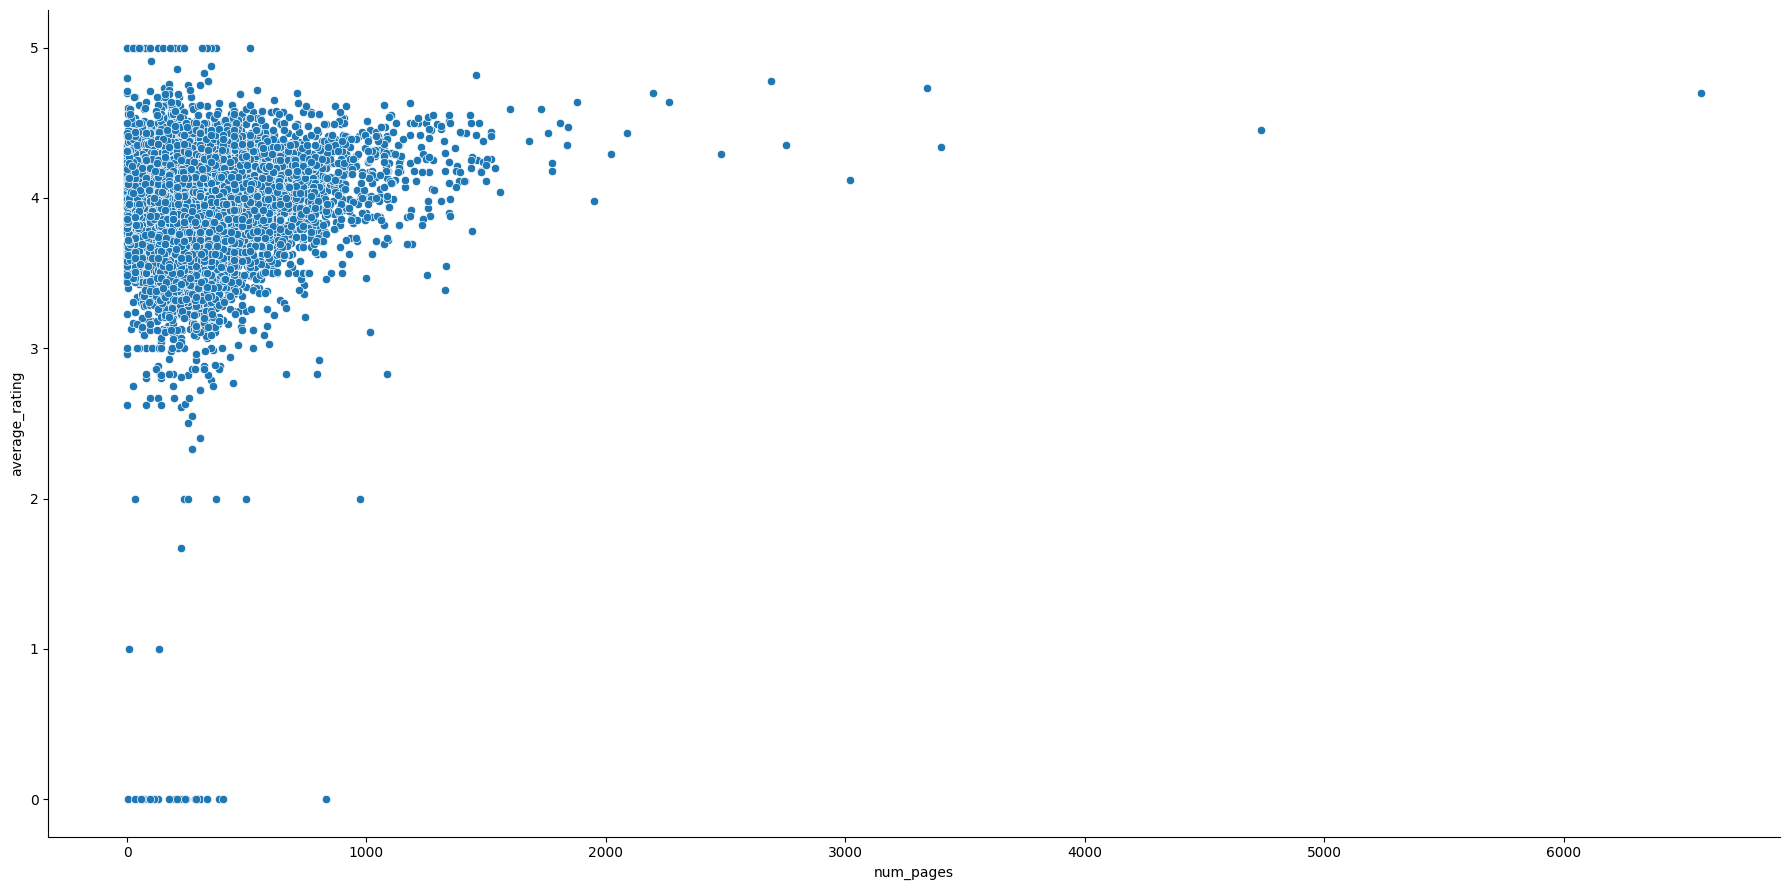

In [30]:
sns.relplot(x="num_pages", y="average_rating", data=df, height=9, aspect = 2)

<Axes: xlabel='year', ylabel='text_reviews_count'>

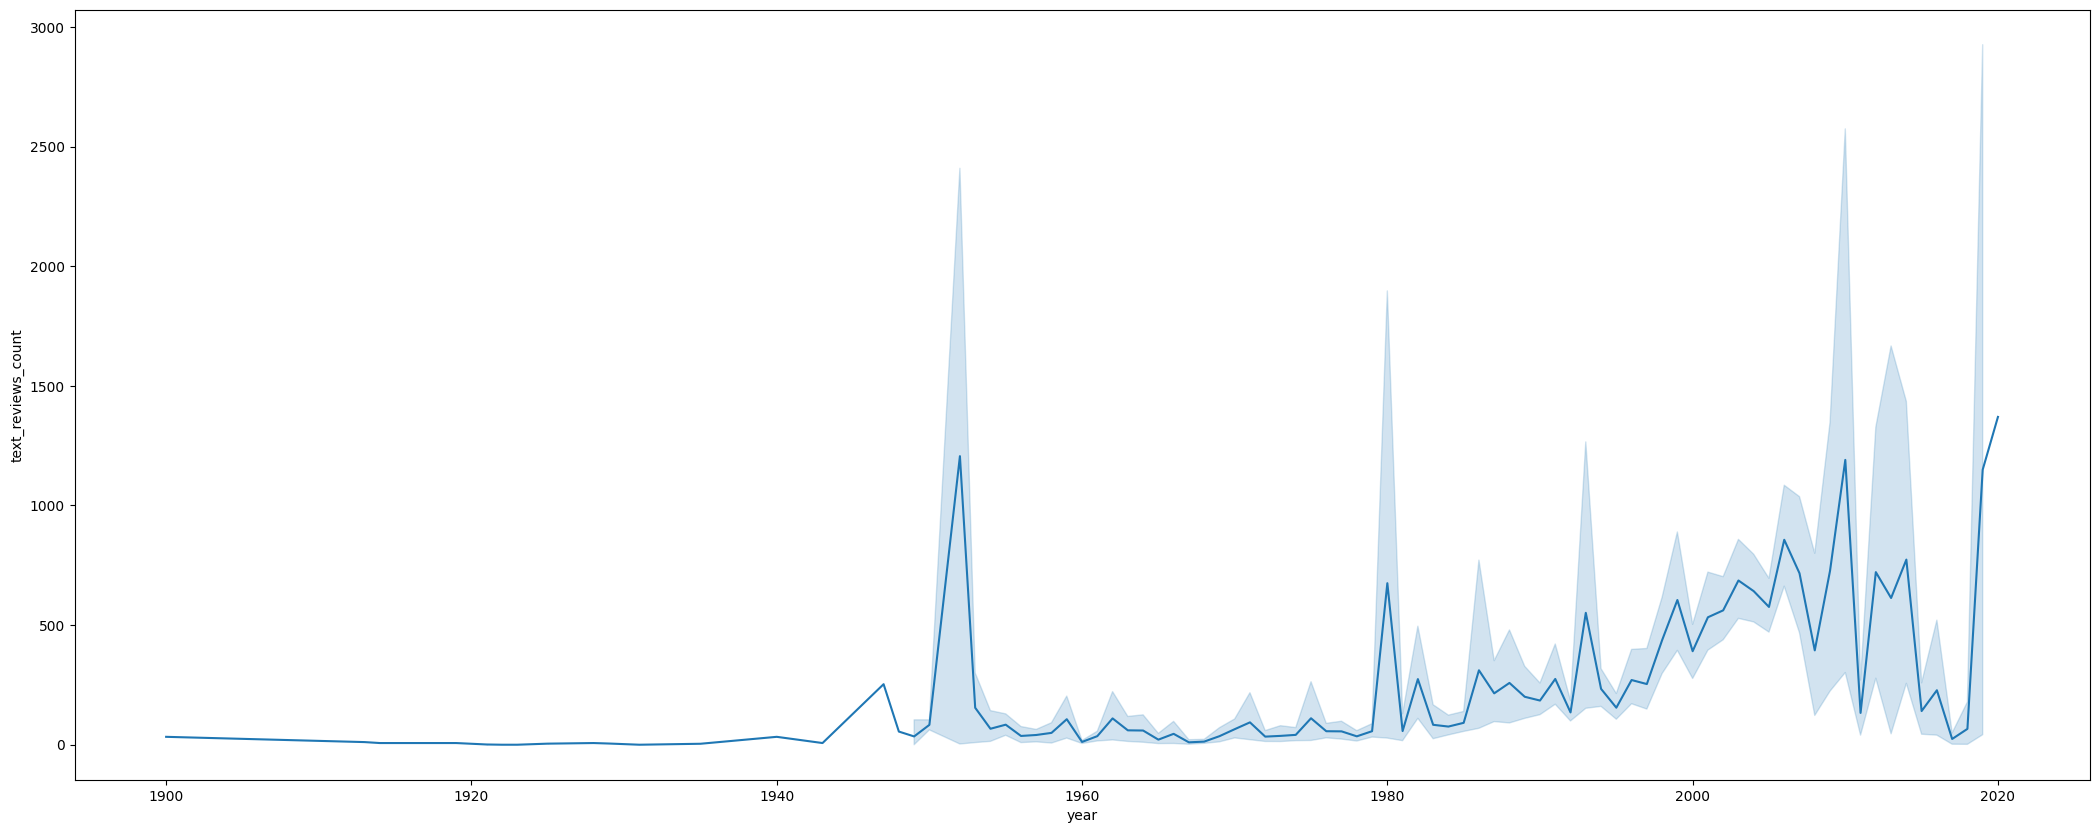

In [31]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
sns.lineplot(x="year", y="text_reviews_count", data=df)

### We can see from the visual above that starting from the 80s, the rate/number of reviews is getting higher than before.
### This could be attributed to the effect of the internet picking up and people shareing more reviews and thoughts online.

# 5. Creating Model

### We will be training four models and pick one based on performance on the test data:
1. AdaBoost Model
2. Linear Regression Model
3. Ridge Regression Model
4. Random Forest Model

In [32]:
label = df['average_rating'].values
df.drop(['bookID', 'title', 'authors', 'isbn', 'isbn13', 'publication_date', 'publisher', 'average_rating'], axis=1, inplace=True)

In [33]:
# Split the Data into 70% - 30% for train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.3)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4))

parameters = {
    'learning_rate': [0.001, 0.01, 0.02, 0.1, 0.2, 1.0],
    'n_estimators': [10, 50, 100, 200]
}

grad_Ada = GridSearchCV(model, parameters, refit=True)
grad_Ada.fit(X_train, y_train)

print('Best Score: ', grad_Ada.best_score_*100, '\nBest Parameters: ', grad_Ada.best_params_)

Best Score:  93.14043713523648 
Best Parameters:  {'learning_rate': 0.02, 'n_estimators': 200}


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

model  = LinearRegression()

parameters = {
    'fit_intercept': [True, False],
}

grad_Linear = GridSearchCV(model, parameters, refit=True)
grad_Linear.fit(X_train, y_train)

print('Best Score: ', grad_Linear.best_score_*100, '\nBest Parameters: ', grad_Linear.best_params_)

Best Score:  77.27720716829015 
Best Parameters:  {'fit_intercept': True}


In [39]:
from sklearn.linear_model import Ridge

model = Ridge()

parameters = {
    'fit_intercept': [True, False],
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

grad_ridge = GridSearchCV(model, parameters, refit=True)
grad_ridge.fit(X_train, y_train)

print('Best Score: ', grad_ridge.best_score_*100, '\nBest Parameters: ', grad_ridge.best_params_)

Best Score:  77.27719334927319 
Best Parameters:  {'alpha': 0.001, 'fit_intercept': True}


In [37]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10, 12, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15]
}

grad_rf = GridSearchCV(model, parameters, refit=True, cv=10)
grad_rf.fit(X_train, y_train)

print('Best Score: ', grad_rf.best_score_*100, '\nBest Parameters: ', grad_rf.best_params_)

Best Score:  98.55459891472951 
Best Parameters:  {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}


In [41]:
l = []
l.append(('AdaBoost', grad_Ada.best_score_*100))
l.append(('Linear Regression', grad_Linear.best_score_*100))
l.append(('Ridge Regression', grad_ridge.best_score_*100))
l.append(('Random Forest', grad_rf.best_score_*100))
scores = pd.DataFrame(l, columns =['Model', 'Train Score'])

# 6. Make Predictions using the 4 Models

In [72]:
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

## AdaBoost Model

In [73]:
# AdaBoost Model
pred_adaboost = grad_Ada.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_adaboost - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_adaboost))))
print('Model Score on Test Data: ', grad_Ada.score(X_test, y_test))

Residual sum of squares:  0.006525180197627225
RMSE: 0.08077858749462771
Model Score on Test Data:  0.9588548854748151


#### Features Importance

In [74]:
perm = PermutationImportance(grad_Ada.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
1.6937 ± 0.0472,rate_occ
0.0943 ± 0.0046,num_occ
0.0019 ± 0.0015,rate_per_pages
0.0005 ± 0.0001,ratings_count
0.0000 ± 0.0000,text_reviews_count
0.0000 ± 0.0000,year
0.0000 ± 0.0000,num_pages
0.0000 ± 0.0000,rate_weight_2
0 ± 0.0000,language_code
-0.0000 ± 0.0000,rate_weight


<Axes: >

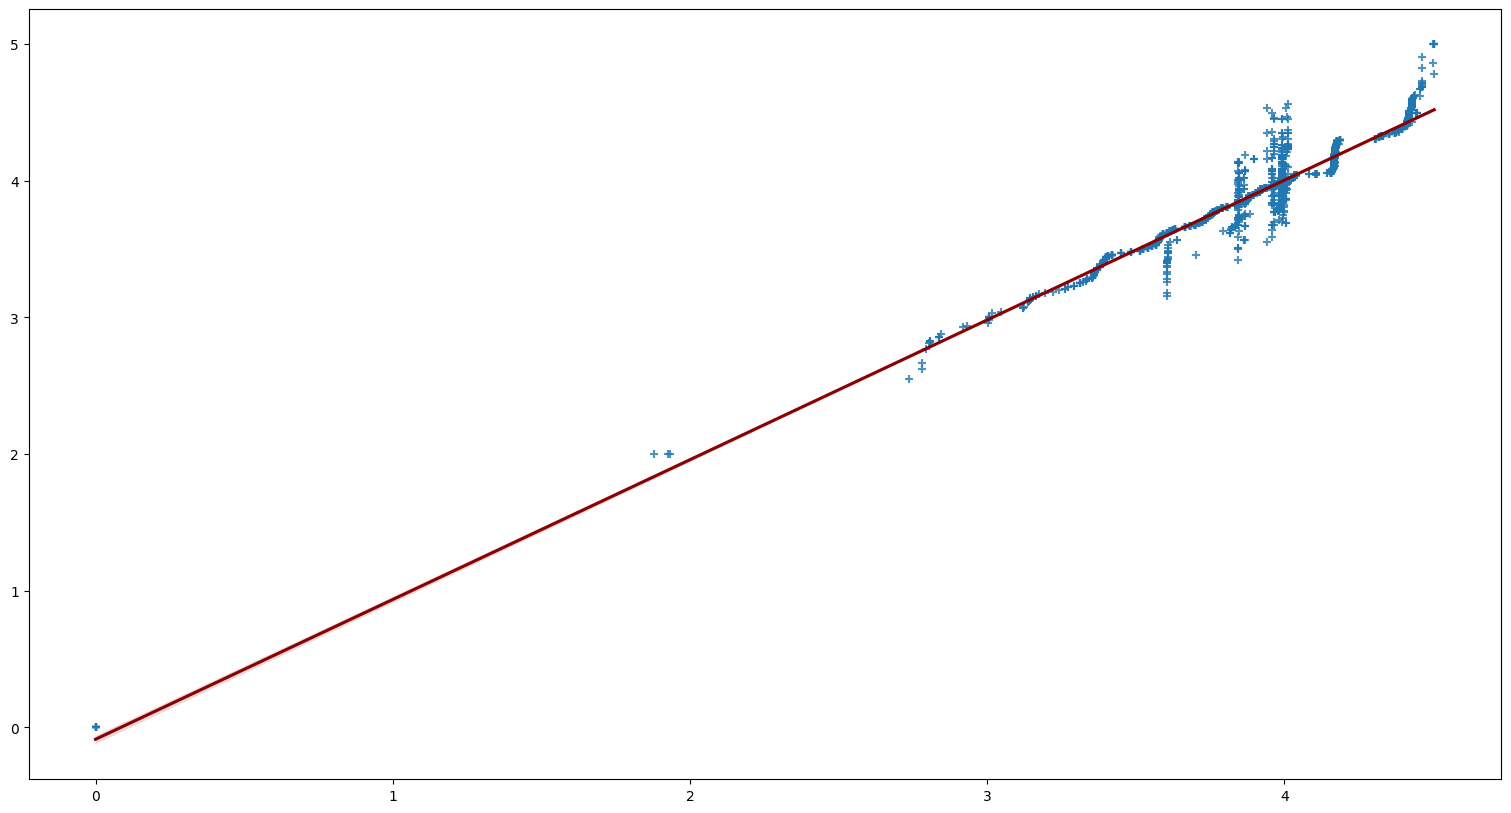

In [75]:
plt.figure(figsize=(19,10))
sns.regplot(x=pred_adaboost, y=y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

## Linear Regression Model

In [76]:
# Linear Regression Model
pred_lr = grad_Linear.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_lr - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_lr))))
print('Model Score on Test Data: ', grad_Linear.score(X_test, y_test))

Residual sum of squares:  0.02356871478719784
RMSE: 0.1535210564945338
Model Score on Test Data:  0.8513853350006635


#### Features Importance

In [77]:
perm = PermutationImportance(grad_Linear.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
36.5451 ± 0.7596,rate_occ
35.8743 ± 1.2263,num_occ
6.2787 ± 0.1215,rate_per_pages
5.7062 ± 0.2717,num_pages
0.2712 ± 0.0082,ratings_count
0.2420 ± 0.0057,rate_weight_2
0.2043 ± 0.0102,rate_weight
0.2025 ± 0.0089,text_reviews_count
0.0002 ± 0.0003,language_code
-0.0000 ± 0.0000,year


<Axes: >

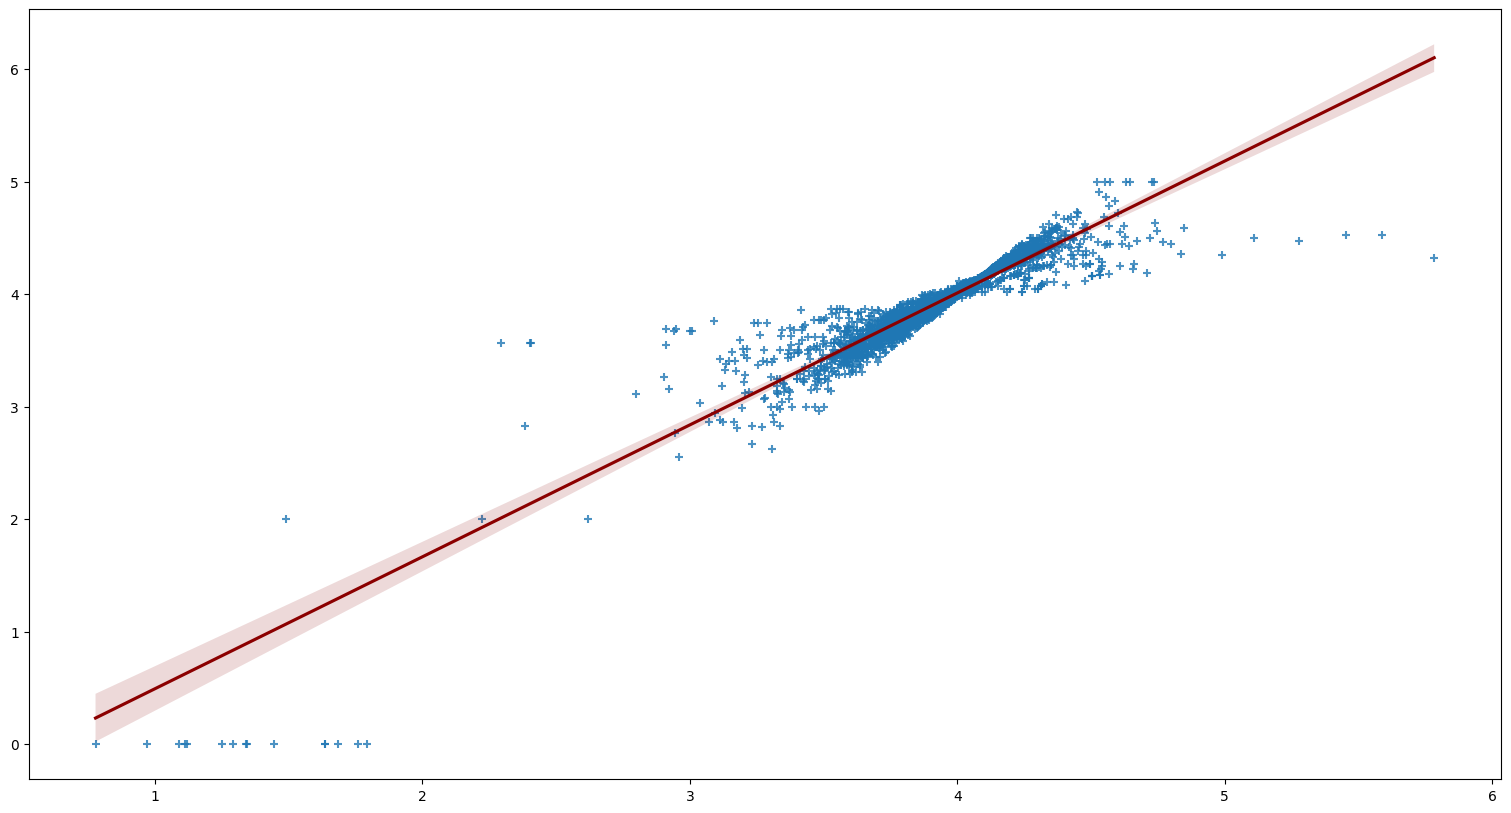

In [78]:
plt.figure(figsize=(19,10))
sns.regplot(x=pred_lr, y=y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

## Ridge Regression Model

In [79]:
# Ridge Regression Model
pred_ridge = grad_ridge.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_ridge - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_ridge))))
print('Model Score on Test Data: ', grad_ridge.score(X_test, y_test))

Residual sum of squares:  0.023568987075049647
RMSE: 0.15352194330143704
Model Score on Test Data:  0.851383618064961


#### Features Importance

In [80]:
perm = PermutationImportance(grad_ridge.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
36.5436 ± 0.7596,rate_occ
35.8728 ± 1.2262,num_occ
6.2791 ± 0.1216,rate_per_pages
5.7066 ± 0.2717,num_pages
0.2712 ± 0.0082,ratings_count
0.2420 ± 0.0057,rate_weight_2
0.2043 ± 0.0102,rate_weight
0.2025 ± 0.0089,text_reviews_count
0.0002 ± 0.0003,language_code
-0.0000 ± 0.0000,year


<Axes: >

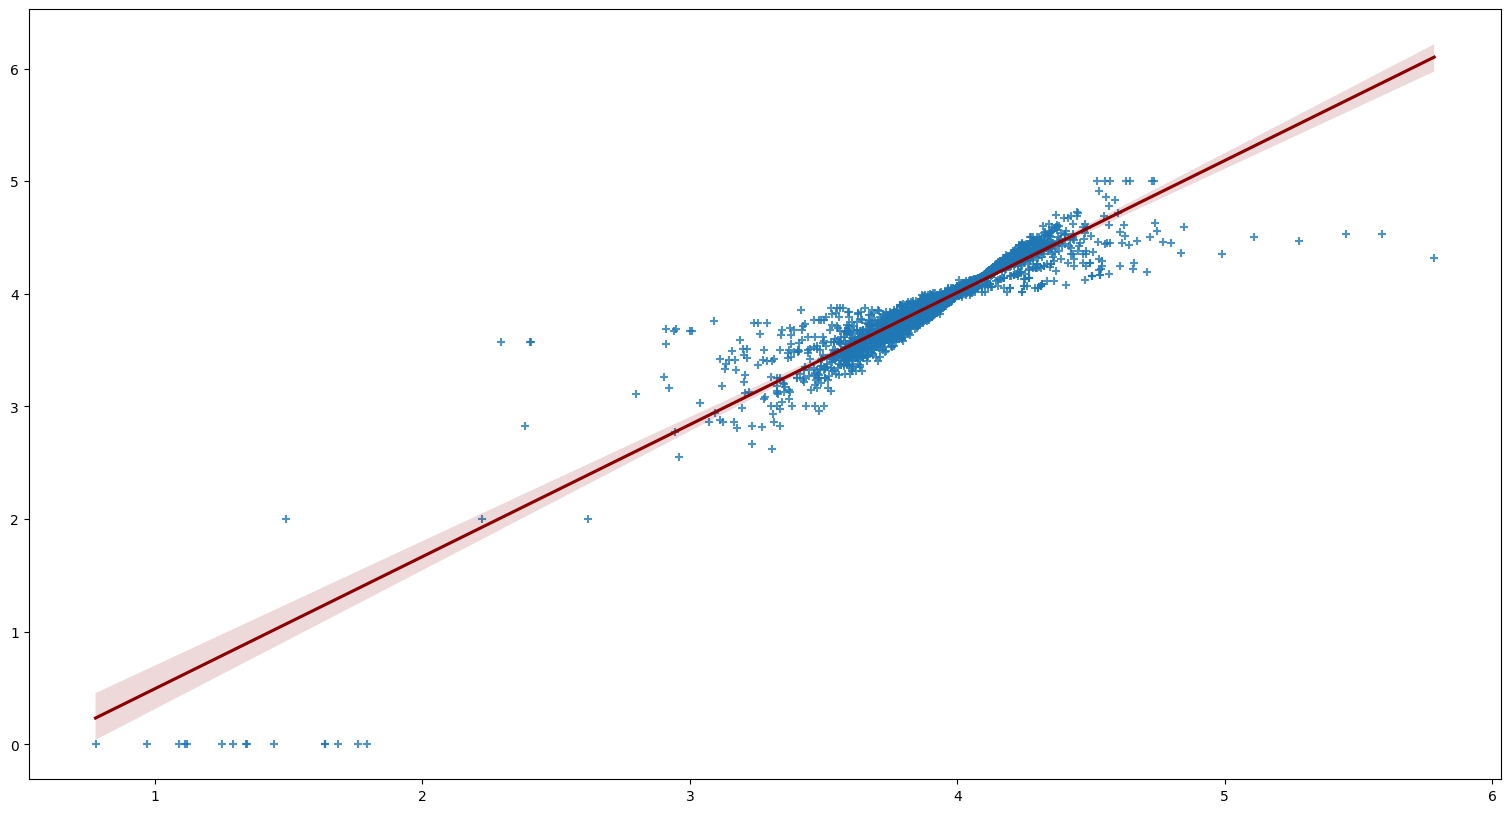

In [81]:
plt.figure(figsize=(19,10))
sns.regplot(x=pred_ridge,y=y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

## Random Forest Model

In [82]:
# Random Forest Model
pred_rf = grad_rf.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_rf - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_rf))))
print('Model Score on Test Data: ', grad_rf.score(X_test, y_test))

Residual sum of squares:  0.0017604099531430685
RMSE: 0.04195723957963713
Model Score on Test Data:  0.9888995756531466


#### Features Importance

In [83]:
perm = PermutationImportance(grad_ridge.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
36.5436 ± 0.7596,rate_occ
35.8728 ± 1.2262,num_occ
6.2791 ± 0.1216,rate_per_pages
5.7066 ± 0.2717,num_pages
0.2712 ± 0.0082,ratings_count
0.2420 ± 0.0057,rate_weight_2
0.2043 ± 0.0102,rate_weight
0.2025 ± 0.0089,text_reviews_count
0.0002 ± 0.0003,language_code
-0.0000 ± 0.0000,year


<Axes: >

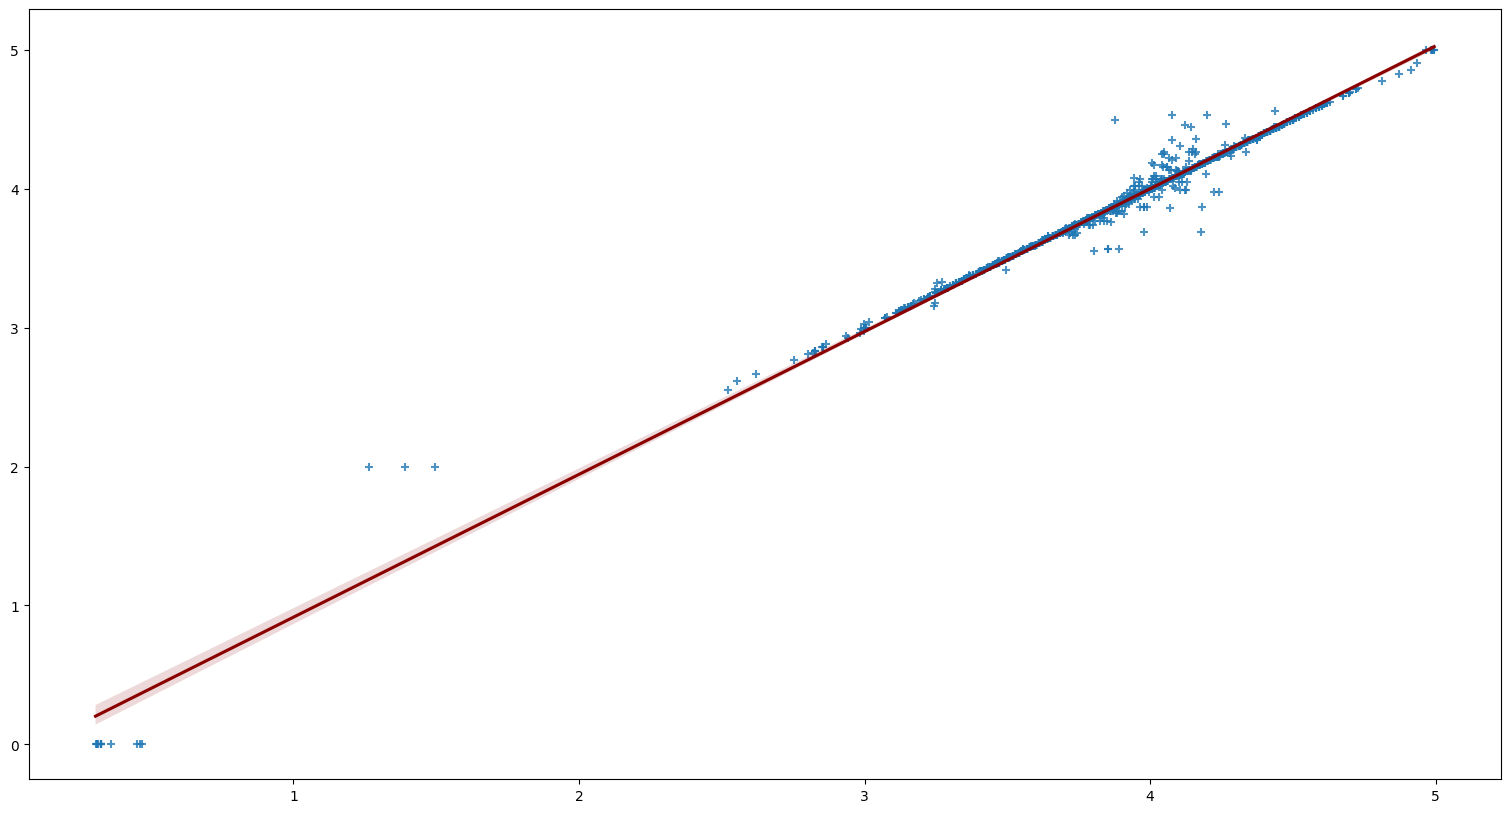

In [84]:
plt.figure(figsize=(19,10))
sns.regplot(x=pred_rf,y=y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

In [85]:
l2 = []
l2.append(('AdaBoost', grad_Ada.score(X_test, y_test)*100))
l2.append(('Linear Regression', grad_Linear.score(X_test, y_test)*100))
l2.append(('Ridge Regression', grad_ridge.score(X_test, y_test)*100))
l2.append(('Random Forest', grad_rf.score(X_test, y_test)*100))

test_scores = pd.DataFrame(l2, columns =['Model', 'Test Score'])

## Comparison of results from the four models

In [86]:
scores['Test Score'] = test_scores['Test Score']
scores

,Model,Train Score,Test Score
0,AdaBoost,93.140437,95.885489
1,Linear Regression,77.277207,85.138534
2,Ridge Regression,77.277193,85.138362
3,Random Forest,98.554599,98.889958


<Axes: >

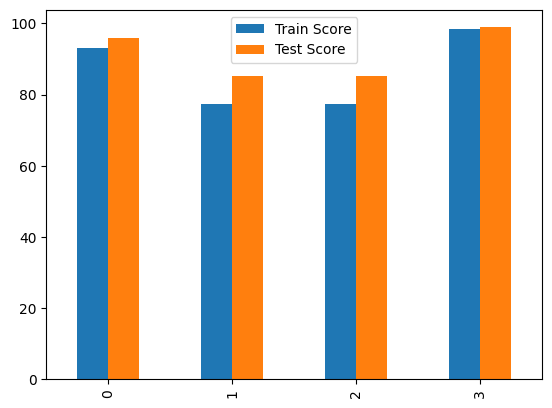

In [87]:
scores.plot.bar()

###The Random Forest model has the highest Test Score at approximately 98.8, which indicates it is the best performing model among those tested. This suggests that the Random Forest model is the most accurate in predicting the ratings on unseen data and would be the recommended model to use in the bookstore to derive insights and drive decisions.



In [88]:
# Exporting the model
dump(grad_rf, '/content/drive/My Drive/ratings_prediction_model.joblib')

['/content/drive/My Drive/ratings_prediction_model.joblib']